In [23]:
# Import needed packages and potential data science tools like pandas and numpy
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

## Data Preparation & Pre-processing 

To begin this machine learning effort aimed at answering the two following research questions,
1. Can you predict passenger satisfaction?
2. What factors are associated with passenger satisfaction?

we first need to read-in our data files and correctly concatenate the two sources.  After ensuring that the dataframes were in the identical format, we were able to "stack" them on-top of one another to create a complete datasource that can be used to predict passenger satisfaction.  The next steps were to dive into the different distributions of our predicting factors, to potentially find column's suitable for dummification, which is essentially transforming a categorical variable to be represented in the form of 1's and 0's usually representing Yes and No (but can be flipped).  This could prove beneficial to reduce the overall computing power used when running our model's, as we would not need to apply intense dummification during fitting or "training", but rather focus on tuning and the appropriate feature inputs. Due to our binary target variable (2 groups) it makes sense and reduces compute power as well to also transform *'Satisfaction'* to be in the form of **1 for Satisfied passengers** and **0 for neutral or dissatisfied passengers**.

In [24]:
# Read-in the data as two files and we will concatenate them
data1 = pd.read_csv("/Users/rileysvensson/Desktop/GSB 545 - Advanced Machine Learning/data /data1.csv")
data2 = pd.read_csv("/Users/rileysvensson/Desktop/GSB 545 - Advanced Machine Learning/data /data2.csv")

# View head of each dataset to ensure they are identical before stacking, which is true with 25 columns (23 without id's)
data1.head(5)
data2.head(5)

# Stack these two df's to create a complete dataset
passenger_data = pd.concat([data1, data2], ignore_index=True)

### Pre-processing

In [25]:
# Drop the id columns which are unique for each record and thus provides no predictability and would lead to overfitting
passenger_data_final = passenger_data.drop(['Unnamed: 0','id'], axis = 1)


# Check for missing values before modeling, and we find that there is only 393 missing values for 'Arrival Delay'
# which can be dropped without losing preditability as we have over 129,000 records
passenger_data_final.isnull().sum()

# Drop-na's which will remove 393 records with missing values for Arrival Delay
passenger_data_final = passenger_data_final.dropna().copy()

# First column that I inspected to be suitable for dummification is CustomerType, followed by all variables in which 
# I thought to be binary 

passenger_data_final['Customer Type'].value_counts()  # binary
passenger_data_final['Type of Travel'].value_counts() # binary
passenger_data_final['Class'].value_counts()          # 3 different classes so left for dummification during modeling
passenger_data_final['Gender'].value_counts()         # binary 
passenger_data_final['satisfaction'].value_counts()   # binary

# Dummifying needed variables by using get dummies and keep all dummies to ensure it worked correctly and be able to select which class I want as 1
passenger_data_dummy = pd.get_dummies(passenger_data_final, columns=['Customer Type', 'Type of Travel', 'Gender', 'satisfaction'], drop_first=False)

# View the dataset to ensure correct operations and proceed to dropping now repeated columns
passenger_data_dummy = passenger_data_dummy.drop(['Customer Type_disloyal Customer','Type of Travel_Personal Travel',
                                                 'Gender_Female','satisfaction_neutral or dissatisfied'], axis = 1)

# View head of pre-processed dataframe
passenger_data_dummy.head(5)

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_Loyal Customer,Type of Travel_Business travel,Gender_Male,satisfaction_satisfied
0,52,Eco,160,5,4,3,4,3,4,3,...,5,2,5,5,50,44.0,1,1,0,1
1,36,Business,2863,1,1,3,1,5,4,5,...,4,3,4,5,0,0.0,1,1,0,1
2,20,Eco,192,2,0,2,4,2,2,2,...,3,2,2,2,0,0.0,0,1,1,0
3,44,Business,3377,0,0,0,2,3,4,4,...,1,3,1,4,0,6.0,1,1,1,1
4,49,Eco,1182,2,3,4,3,4,1,2,...,2,4,2,4,0,20.0,1,1,0,1


As hypothesized and confirmed by the data dictionary, the *'Customer Type'* column only consists of 2 classes, Loyal Customer or disloyal.  This provides an opportunity to dummify this column before any modeling occurs, to reduce some compuational power later on, as each iteration would require this preprocessing step.  Another benefit that was realized after dummifiying the first two columns, *'Customer Type'* and *'Travel Type'* is that we can now easily create an interaction between the two, to test if there is a effect shared between, such as more loyal customer's coming from business travelers.  We applied this dummification to our target variable and any other appropriate predictors like Gender.

As a final check before moving onto exploratory data visualization and thinking about potential feature sets that can be used to predict if a passenger is 'Satisfied', we inspected the data types of each remaining variables to ensure they were appropriate.  For the ordinal variables derived from surveys given to airline passengers, to leverage the order of the data and preserve information about what the responses mean, we chose to treat them as practical numbers, thus reducing computational power required to bin them into categories. After further inspection, we only have 1 categorical or 'object' datatype in the *'Class'* variable, while the remaining potential predictors consist of ordinal survey scores (kept numeric), discretely measured values like passenger Ages, and continuous decimals like *'Arrival Delay in Minutes'*.  We are now ready to move into exploratory visualization and summary statistics of the data to better inform our feature selection process on what contributes to a passenger's satisfaction.

## Exploratory Data Analysis 

Before performing any modeling, it is best practice and required to take a dive into the data, becoming familiar with its patterns and overall relationships, that can guide our feature selection process.  To begin, I created a few contingency tables to compare the counts of different groups, searching for any evidence supporting an interaction or effect gained from multiplying two numerical variables.  I first started with exploring the counts of Customer Type: Loyal or Not, and Type of Travel: Business or Personal, to visualize if business travelers are more loyal to an airline due to their potential reliance on the service for work. 

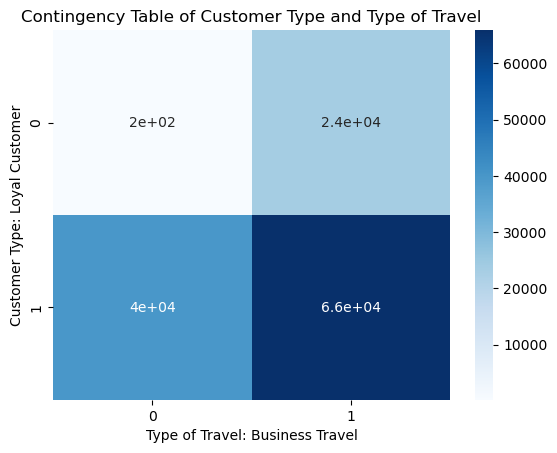

In [26]:
# Inspect our data types to ensure they are correct before beginning exploratory analysis
passenger_data_dummy.dtypes

# Create a contingency table using crosstab function from Pandas to search for an interaction
contingency_table = pd.crosstab(passenger_data_dummy['Customer Type_Loyal Customer'], 
                                passenger_data_dummy['Type of Travel_Business travel'])

# Plotting the heatmap using Seaborn as it was the most straightforward, plotnine requires no spaces in column names
sns.heatmap(contingency_table, annot=True, cmap='Blues', cbar=True)

# Matplotlib allows for axis adjustments
plt.title('Contingency Table of Customer Type and Type of Travel')
plt.xlabel('Type of Travel: Business Travel')
plt.ylabel('Customer Type: Loyal Customer')
plt.show()


As expected, a significantly higher number of loyal customers travel for business (66,000) compared to non-loyal customers (24,000), which could suggest that there is an interaction between these two variables which could prove useful to predict their satisfaction.  If there are more loyal customers traveling for business reasons, it could be that these type of people are also more likely to be satisfied, due to checking both of these boxes.

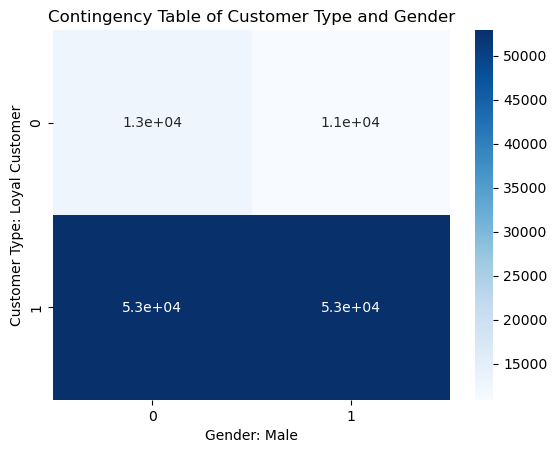

In [27]:
# Create another contingency table using crosstab function from Pandas
contingency_table_gender_loyalty = pd.crosstab(passenger_data_dummy['Customer Type_Loyal Customer'], 
                                               passenger_data_dummy['Gender_Male'])

# Plotting the heatmap using Seaborn as it was the most straightforward, plotnine requires no spaces in column names
sns.heatmap(contingency_table_gender_loyalty, annot=True, cmap='Blues', cbar=True)

# Matplotlib allows for axis adjustments
plt.title('Contingency Table of Customer Type and Gender')
plt.xlabel('Gender: Male')
plt.ylabel('Customer Type: Loyal Customer')
plt.show()


Based on this contingency table, there seems to be no need for an interaction term between gender and customer type, which suggests that any differences in outcomes like satisfaction are likely not driven by the combination of these two factors.  We can see this because being Male or Female has no effect on the number of Loyal Customers, meaning that there are an equal number of loyal Males and Females.  It's worth noting that I also created a contingency table illustrating the counts of each gender and travel type: business or personal.  It revealed that 2,000 more women partake in business travel than men, but in terms of the mass volume of our data this is not statistically significant and does not require an interaction.

Next, I proceeded to effectively visualize the data in the form of stacked bar charts, showcasing the varying counts of respondents for the ordinal survey questions as well as other categorical predictors, segmented by Satisfied and Neutral/Dissatisfied categories.  If any graph revealed a clear distinction between Satisfied and Dissatisfied passengers, then this suggests that including this variable in our models with enhance our predictive ability.  On the other hand, if a visual displays no difference in counts across our target variable, Satisfaction, then we can remove it from the feature set and test if our model improves, as it is likely only attributing noise during training.  

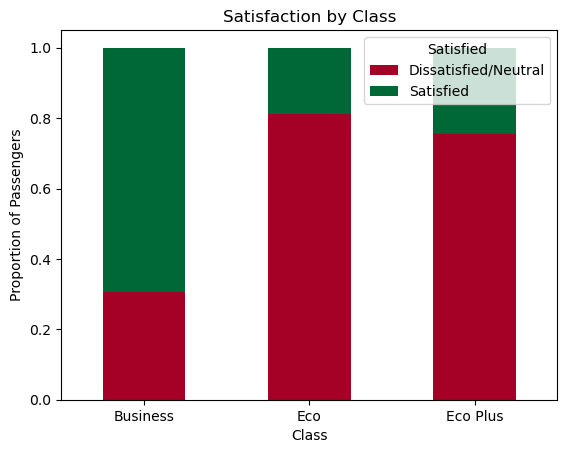

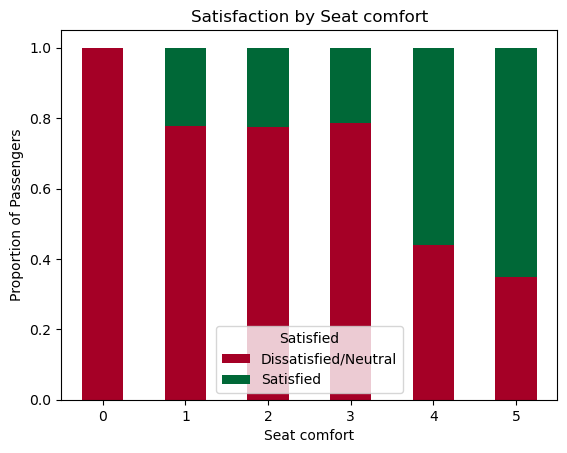

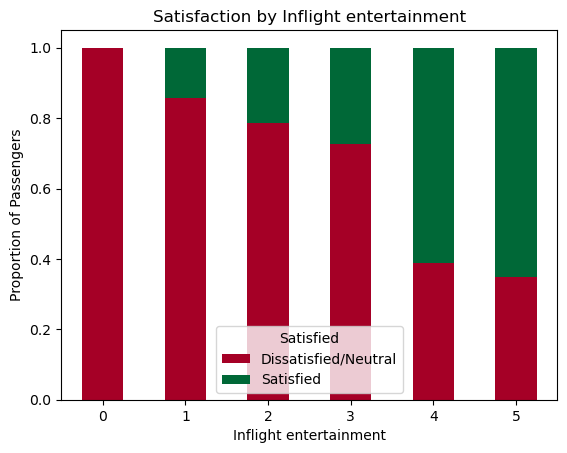

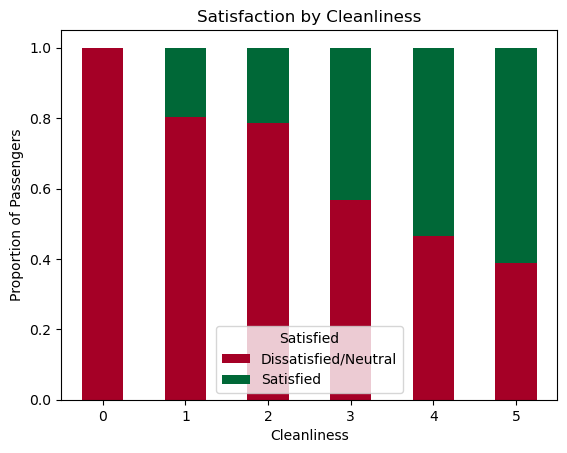

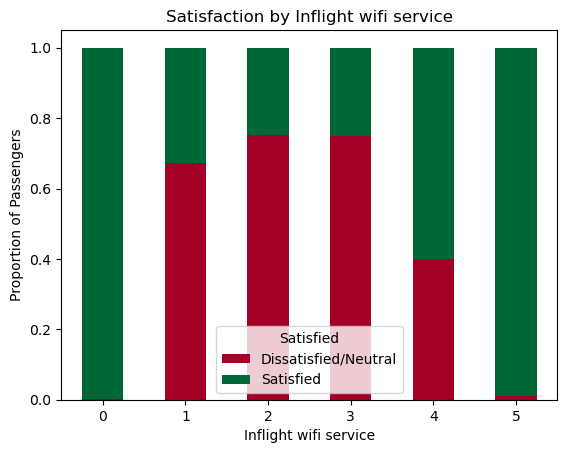

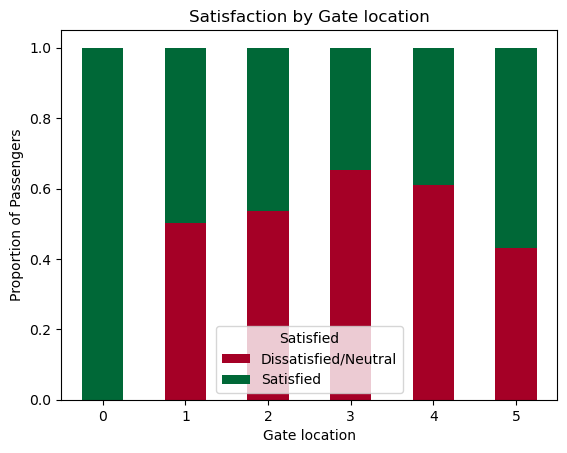

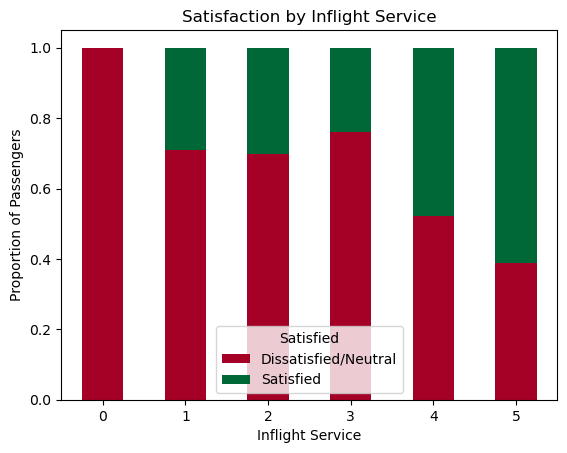

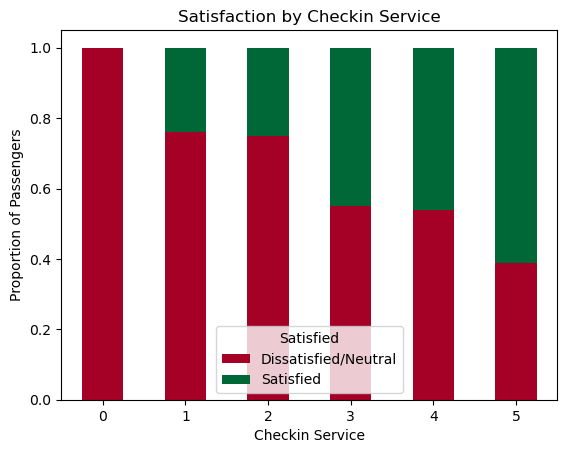

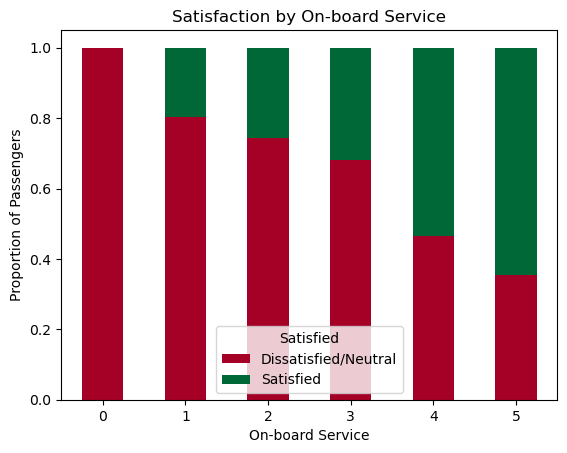

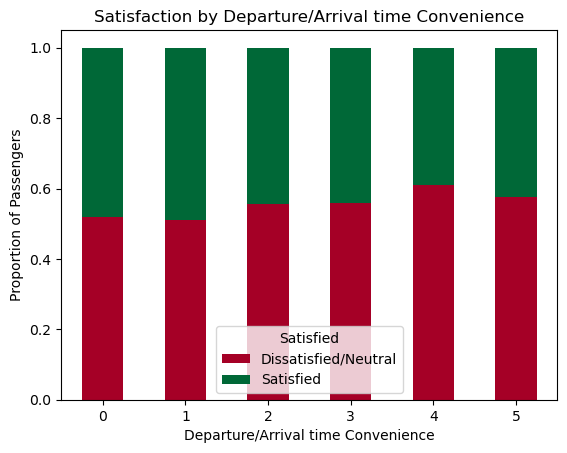

In [28]:
# Create a crosstab of Class and satisfaction
crosstab = pd.crosstab(passenger_data_dummy['Class'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')

# Plotting the stacked bar chart: Satisfaction vs Class
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Class')
plt.xlabel('Class')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# Repeating the process for ordinal columns, Note: only including significant results shaping our analysis
# Seat Comfort
crosstab = pd.crosstab(passenger_data_dummy['Seat comfort'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Seat comfort')
plt.xlabel('Seat comfort')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()


# Inflight entertainment
crosstab = pd.crosstab(passenger_data_dummy['Inflight entertainment'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Inflight entertainment')
plt.xlabel('Inflight entertainment')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# Cleanliness
crosstab = pd.crosstab(passenger_data_dummy['Cleanliness'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Cleanliness')
plt.xlabel('Cleanliness')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# Unusual Effect
# Inflight wifi service
crosstab = pd.crosstab(passenger_data_dummy['Inflight wifi service'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Inflight wifi service')
plt.xlabel('Inflight wifi service')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# Unusual Effect
# Gate Location
crosstab = pd.crosstab(passenger_data_dummy['Gate location'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Gate location')
plt.xlabel('Gate location')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()


# Inflight Service
crosstab = pd.crosstab(passenger_data_dummy['Inflight service'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Inflight Service')
plt.xlabel('Inflight Service')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# Check-in Service
crosstab = pd.crosstab(passenger_data_dummy['Checkin service'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Checkin Service')
plt.xlabel('Checkin Service')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# On-board Service
crosstab = pd.crosstab(passenger_data_dummy['On-board service'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by On-board Service')
plt.xlabel('On-board Service')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()

# No clear pattern example 
# Departure Arrival Time Convenience
crosstab = pd.crosstab(passenger_data_dummy['Departure/Arrival time convenient'], passenger_data_dummy['satisfaction_satisfied'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='RdYlGn')
plt.title('Satisfaction by Departure/Arrival time Convenience')
plt.xlabel('Departure/Arrival time Convenience')
plt.ylabel('Proportion of Passengers')
plt.xticks(rotation=0)
plt.legend(title='Satisfied', labels=['Dissatisfied/Neutral', 'Satisfied'])
plt.show()



The first graph, *Satisfaction by Class* clearly indicates that satisfaction levels vary significantly across different travel classes, Business, Economy and Economy Plus. Specifically, passengers in Business class appear to be largely satisfied (approximately 70% satisfaction), whereas those in either Economy type,show higher proportions of dissatisfaction or neutrality, suggesting that the class of service has a notable impact on passenger satisfaction, and should be used in modeling.

The second graph, *Satisfaction by Seat Comfort* shows that seat comfort also likely has a significant impact on passenger satisfactios. Every passenger who rated their seat comfort a "0" was marked as dissatisfied/neutral, indicating a clear negative correlation. Furthermore, as the seat comfort rating increases from "1" to "5", the proportion of satisfied passengers substantially increases, highlighting that better seat comfort strongly correlates with higher satisfaction levels.  Our third graph, displaying *Satisfaction by Inflight Entertainment* follows the same trend as seat comfort, implying that inflight entertainment is a factor that attributes to satisfied passengers.  These factors are not alone, as *Cleanliness* scores also display a positive correlation with satisfaction, indicating its potential as a modeling predictor.

However in the fourth plot, we run into our first example of an unusual or non-significant effect of a predictor on passenger satisfaction.  The visual displays *Satisfaction by Inflight Wifi Service*, and suggests that inflight wifi  might not significantly impact overall passenger satisfaction. We can infer this because all passengers rating the wifi service as "0" were still satisfied, indicating that wifi may not crucial to passengers' overall travel experience, or is useful and follows and adverse effect as expected.

Lastly, the three graphs comparing overall service segments: Check-in, Inflight and On-board, to overall passenger Satisfaction, all illustrate a clear trend where customer satisfaction increases as the scores for service quality improve from low scores (0 - poor) to high scores (5 - great). These trends highlight that both inflight and check-in services are critical indicators of overall passenger satisfaction, as better service in these areas contributes significantly to a more satisfactory flight experience.  Any other visuals created, resulted in no clear patterns, such as Departure/Arrival time convenience and satisfaction, inferring that they may be poor predictors for our analysis.


## Feature Selection

### Creating Interactions

Following our Exploratory Analysis of the data and how each is related to Satisfaction, we have an idea of which columns could be dropped to improve our predictive ability.  To ensure that they are being appropriately removed, we will run a preliminary baseline model with all features, measure its performance, and then remove our 'noisy' variables and watch for improvement.  In this process, I found that the only variable that increased our accuracy rate when removed, was *Departure/Arrival time convenient*, which showed no relationship with satisfaction levels.  This is somewhat intuitive as a customer in in-chare of selecting the time at which they wish to depart and arrive based on the arilines options, which is only subject to change when faced with rare delays. 

In [29]:
# Create an interaction between LoyalCustomerStatus and TravelType Business 
passenger_data_dummy['CustomerLoyal_BusinessTraveler_int'] = passenger_data_dummy['Customer Type_Loyal Customer'] * passenger_data_dummy['Type of Travel_Business travel']

# View df
passenger_data_dummy.head(5)

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Customer Type_Loyal Customer,Type of Travel_Business travel,Gender_Male,satisfaction_satisfied,CustomerLoyal_BusinessTraveler_int
0,52,Eco,160,5,4,3,4,3,4,3,...,2,5,5,50,44.0,1,1,0,1,1
1,36,Business,2863,1,1,3,1,5,4,5,...,3,4,5,0,0.0,1,1,0,1,1
2,20,Eco,192,2,0,2,4,2,2,2,...,2,2,2,0,0.0,0,1,1,0,0
3,44,Business,3377,0,0,0,2,3,4,4,...,3,1,4,0,6.0,1,1,1,1,1
4,49,Eco,1182,2,3,4,3,4,1,2,...,4,2,4,0,20.0,1,1,0,1,1


### Define Feature Sets

In this code chunk, we define our baseline feature set including all possible predictors, and our final subset in which *Departure/arrival time convenient* is dropped. The following code creates our column transformer, which is a pipeline used to pre-process our data, by applying further dummification and scaling to the appropriate data types.

In [30]:
# Define different X and Y sets based on intuition of relevant features 

X = passenger_data_dummy.drop(["satisfaction_satisfied"], axis = 1)
y = passenger_data_dummy["satisfaction_satisfied"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)


# Try feature set 2: removing insignificant variables from EDA 

X_2 = passenger_data_dummy.drop(["satisfaction_satisfied","Departure/Arrival time convenient"], axis = 1)

X2_train, X2_test, y_train, y_test = train_test_split(X_2, y, test_size=0.3, random_state = 42)


### Create Column Transformer

In [31]:
# Define column transformer for preprocessing models like NeuralNetworks, XgBoost
ct_all = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough" 
).set_output(transform = "pandas")


## Modeling

### Model's 1 & 2: XGBoost

The initial baseline model, utilizing Extreme Gradient Boosting as our classifier (XGBoost), shows a very impressive predictive performance with an accuracy rate of 96.27 %.  Even including all features, there seems to be minimal noise or overfitting occuring, as we are utilizing a test subset (unseen data to predict our model on) to score our models.  The addition of the interaction variable may have added immense predictive power to our model, however it is more likely that the columns given from the data are simply able to provide a hollistic view of the factors attributing to a passenger's satisfaction.  The next steps consisted of iteratively removing each variable from our second training set (X_2) and comparing our baseline model's performance to get a final feature set, where we can then compare different model types.

In [32]:
# Define a grid of possible weight values that are close to distribution of imbalance target 73,225 / 56,262 = 1.3
pos_weight_values = [1.30, 1.305]
    
# Setup pipeline #1 for XGBoost
xgb_pipeline = Pipeline([
    ("preprocessor", ct_all),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # Parameters needed to suppress warnings
])

# Parameter grid for XGBoost with different parameters being tuned
param_grid_xgb = {
    'classifier__n_estimators': [100,200,300],             
    'classifier__learning_rate': [0.1, 0.3, 0.5],    
    'classifier__max_depth': [3,4],                  
    'classifier__scale_pos_weight': pos_weight_values
}

# Setup GridSearchCV for XGBoost                               # n_jobs -1 tells Jupyter to user all CPU's for gridsearch
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='accuracy', n_jobs= -1)

# Fitting our model on training data
grid_search_xgb.fit(X_train, y_train)

# Best parameters and score
print("Best parameters: ", grid_search_xgb.best_params_)

# Predict on the test set
test_xgb_predictions = grid_search_xgb.predict(X_test)

# Use accuracy_score function
test_acc_xgb = accuracy_score(y_test, test_xgb_predictions)

print("\n Model 1: XGBoost - Accuracy: ", test_acc_xgb)

Best parameters:  {'classifier__learning_rate': 0.3, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 1.3}

 Model 1: XGBoost - Accuracy:  0.9627255643936469


In [12]:
# Generating the confusion matrix to ensure we are not predicting 1's or 0's for all passengers
# Matrix reveals that our model is learning the data well
cm = confusion_matrix(y_test, test_xgb_predictions)
cm

array([[21208,   608],
       [  840, 16191]])

We produced a confusion matrix, which displays a sense of how correct we were able to predict the target variable. The corner squares, of True Positives (where it was 1 and we predicted 1) and True Negative (where it was a 0 and we predicted 0) are the areas of our model in which we wish to maximize.  However it is inportant to ensure to have varying predictions to achieve this, and not just select 1 or 0 for every record. In our case the confusion matrix shows a well-balanced model.

### Final Feature Set

The removal of *Departure/arrival time convenient* in our final feature resulted in a minor yet noticable increase in our model's accuracy, to 96.285 %.  It's important to note that this improvement is only minor within our method of XgBoost, however removing this variable could drastically improve the performance of a more advanced model like a Neural Network, and any other feature dropped resulted in lower accuracies.

In [33]:
# Define a grid of possible weight values that are close to distribution of imbalance target 73,225 / 56,262 = 1.3
pos_weight_values = [1.30, 1.305]
    
# Setup pipeline #1 for XGBoost
xgb_pipeline = Pipeline([
    ("preprocessor", ct_all),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  # Parameters needed to suppress warnings
])

# Parameter grid for XGBoost with different parameters being tuned
param_grid_xgb = {
    'classifier__n_estimators': [100,200,300],             
    'classifier__learning_rate': [0.1, 0.3, 0.5],    
    'classifier__max_depth': [3,4],                  
    'classifier__scale_pos_weight': pos_weight_values
}

# Setup GridSearchCV for XGBoost                         # n_jobs -1 tells Jupyter to user all CPU's for gridsearch
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)

# Fitting our model on training data
grid_search_xgb.fit(X2_train, y_train)

# Best parameters and score
print("Best parameters: ", grid_search_xgb.best_params_)

# Predict on the test set
test_xgb_predictions_2 = grid_search_xgb.predict(X2_test)

# Use accuracy_score function
test_acc_xgb_2 = accuracy_score(y_test, test_xgb_predictions_2)

print("\n Model 2: XGBoost - Accuracy: ", test_acc_xgb_2)

Best parameters:  {'classifier__learning_rate': 0.3, 'classifier__max_depth': 4, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 1.305}

 Model 2: XGBoost - Accuracy:  0.9628542744613484


In [34]:
# Generating the confusion matrix to ensure we are not predicting 1's for all passengers
# Matrix reveals that our model is learning the data well
cm = confusion_matrix(y_test, test_xgb_predictions_2)
cm

array([[21199,   617],
       [  826, 16205]])

### Model 3 - Neural Network

In [63]:
# Model 3 trying individual models to gauge their success

# MLP Pipeline - 1
neural_network = Pipeline([
    ("preprocessor", ct_all),
    ("mlpclassifier", MLPClassifier(max_iter = 1000, early_stopping = True, solver = 'adam'))
])

# Define the parameter grid for tuning, including solver, 1 hidden layer with 100 units, learning rate and activation functions
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(100,)],  
    'mlpclassifier__activation': ['relu', 'tanh', 'logistic','identity'],                              
    'mlpclassifier__learning_rate': ['constant','invscaling','adaptive']
}

# Tuning with GridSearchCV, using accuracy as the scoring metric for classification
grid_search = GridSearchCV(neural_network, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X2_train, y_train)

# Best parameters and score
print("Best parameters: ", grid_search.best_params_)

# Predict on the test set
test_predictions = grid_search.predict(X2_test)
test_acc_nn = accuracy_score(y_test, test_predictions)

print("\n Neural Network - Model 3 - Accuracy: ", test_acc_nn)

Best parameters:  {'mlpclassifier__activation': 'tanh', 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'adaptive'}

 Neural Network - Model 3 - Accuracy:  0.9579375498751512


### Model 4 - Random Forest Regressor

In [29]:
# Model 4 - Set Pipeline for Random Forest Regressor

rf_pipeline = Pipeline([
    ("preprocessor", ct_all),
    ("regressor", RandomForestClassifier())
])

# Define the parameter grid 
param_grid_rf = {
    'regressor__n_estimators': [100, 150, 200], 
    'regressor__max_depth': [None, 10, 20, 30],  
    'regressor__min_samples_leaf': [1, 2, 3, 4, 5] 
}

# Tuning with GridSearchCV, using accuracy as the scoring metric for classification
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy')

grid_search_rf.fit(X2_train, y_train)

# Best parameters and score
print("Best parameters: ", grid_search_rf.best_params_)

# Predict on the test set
test_predictions_rf = grid_search_rf.predict(X2_test)
test_acc_rf = accuracy_score(y_test, test_predictions_rf)

print("\n Random Forest - Model 4 - Accuracy: ", test_acc_rf)

Best parameters:  {'regressor__max_depth': None, 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 150}

 Random Forest - Model 4 - Accuracy:  0.9634978247998558


Following the tuning of Model's 1-4, we were left with a comprehensive view of each individual model's success and usability on this dataset, diving into XgBoost, MLP, and Random Forest's.  The optimal performance accuracy came from our Random Forest bagging tree, which is a robust method to find the best splits in our data for a decision tree, while Xgboost followed decimals behind, due to the semi-imbalanced target variable.  Our Neural Network application reduced accuracy down to 95.7 %, which was significantly lower than the other models, and suggests that it may have learned the quirks of the data, slightly overfitting. As a final modeling step, I included these three impressive estimators, as well as a GradientBoosting and Adaptive Boosting classifiers in a collective 'stacking model'.  The logic here was that any model can be adaptively boosted to target or 'fix' the missclassified records in each iteration, and gradient boosting is another application of AdaBoost that could potentially add some learning to our stacked model.  

## Best Performing Stacking Model

After our preliminary modeling used to determine our optimal stacking model inputs, it was time to run it. Stacking involves training multiple models (base models) on the same training dataset and using a second-level model (meta-model) to combine these predictions. This meta-model is trained on the outputs of the base models as inputs, This which leveragese the strengths of each base model and mitigates their weaknesses, ideally leading to better performance than any single model could achieve. 

In [121]:
# Define base models within the preprocessing pipeline, and tuning with optimal values from Models 1-5
base_models = [
    ('gradient_boosting', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', GradientBoostingClassifier(learning_rate=0.1, max_depth=4, n_estimators=300))
    ])),
    ('xgbboost', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', XGBClassifier(learning_rate = 0.3, max_depth = 4, n_estimators = 300,
                                                  scale_pos_weight = 1.30))
    ])), 
    ('mlp_classifier', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', MLPClassifier(activation = 'relu', hidden_layer_sizes = (100,), 
                                     learning_rate = 'constant', solver = 'adam', max_iter = 1000,
                                     early_stopping = True))
    ])),
    ('ada_boost', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', AdaBoostClassifier(algorithm ='SAMME', n_estimators = 300,
                                          learning_rate = 0.1 ))
     ])),
    ('random_forest', Pipeline([
        ('preprocessor', ct_all),
        ('classifier', RandomForestClassifier(max_depth = None, min_samples_leaf = 1,
                                              n_estimators = 150))
    ]))
]

In [122]:
# Define the final regressor method, typically Linear or Logistic, in this case for classification use Log
final_regressor = LogisticRegression()

# Create the stacking ensemble
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=final_regressor, cv=5)

# Fit the stacking model on train data
stacking_classifier.fit(X2_train, y_train)

# Predict/evaluate the model on Test data
stacking_predictions = stacking_classifier.predict(X2_test)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

# Stacking model performance including final feature set
print("Stacking Model - Accuracy ", stacking_accuracy)

Stacking Model - Accuracy  0.9644760213143873


As we had hoped and expected, the **Stacking model provides the highest accuracy score in predicting if a passenger is Satisfied or Neutral/Dissatisfied**.  This is due to the meta-model learning to combine its learnings from the initial Xgboost, Neural Network, Random Forest, AdaBoost, and GradientBoosted models, producing an overall accuracy of **96.44%**.  To answer our posed research question, an accuracy rate (simply the percentage of how many correct predictions) of 96.44% on unseen data, is strong evidence that we are able to predict a passenger's binary satisfaction based on the 22 predicting factors in our feature set.  In this context, we were not dealing with a severly imbalanced target column, meaning that accuracy is an appropriate scoring metric to gauge our predictive success. 

In terms of each predictors affect on Satisfaction, we can look back to our exploratory visuals to begin to explain their relationship with Satisfaction.  Intuitively and corroborated by our graphs, the following variables are **positively correlated with passenger satisfaction**, as the proportion of satisfied passengers substantially increases as their ordinal survey scores increase from 0 to 5: **Seat Comfort Rating, Inflight Entertainment, Cleanliness, Inflight Service, On-board Service, Checkin Service, Leg-room Service**.  On the other hand, two predictors showed **unexpected relationships with Satisfaction, as Gate Location and Inflight Wifi had 100% satisfaction for those answering 0**, indicating that it does provide predictive importance to our model, however cannot be intuitively explained and requires further research.  We can see from our graph of *Class vs Satisfaction* that those in **Business class are more likely to be satisfied**, while passengers of both economy classes are less satisfied. The contingency table displaying CustomerType:Loyal and BusinessTravel (not personal) showed a clear difference in counts, **explained by more loyal customer's relying on travel for their business than personal trips**.  We also found evidence to suggest that ***Departure/Arrival time convenient* is NOT a significant predictor** in a passenger's satisfaction, displayed by flat rates of survey scores in EDA. 

## Data Source Discussion

Before we conclude with the results of this analysis and how we can use our findings, it's good practice to comment on the integrity of our data source and any potential problems or areas of improvement for the future.  As a few comments, it's important to note that survey data always has the potential for bias, which can come in the form of many ways.  First off, passengers can exaggerate or downplay their scores which can skew actual patterns, or people can get bored with a long, required survey and untruthfully select answers to get through it.  They could also only choose to take this survey if they feel so strongly (negative or positive) on the topic, which does not lend a representative view of our population.  With that said, it may be more beneficial if possible, to collect objective scores from airline subject matter experts, or create a standard way of ranking airline service that can be used across competitors. 

However, a valid point I thought of when carrying out this analysis revolved around the collection of our target variable Satisfaction. As is, the target variable only consists of binary groups, Satisfied and Neutral/Dissatisfied.  This is an issue, are we are losing some valuable information that can be used to classify   neutral vs dissatisfeid people.  An easy fix to this is to collect this column with 3 classes: Satisfied, Neutral, and Dissatisfied.  This way the analyst can choose to dummify it to be Binary like it is now, and predict Satisfied as 1, or treat dissatisifed people as the target, and be able to predict what makes them unhappy.  This can finally be applied to Neutral, to find out the unique factors that attribute to someone feeling indifferent about their experience.  This method is known as the One vs Rest classification method, but cannot be carried out with the data was collected. 

However, with our accuracy of 96.45% this data does provide immense usability for gauging a passenger's satisfaction, and should be continued to be used with these changes in mind.  

## Final Recommendations

The research and results presented in this study have broad applicability for airlines seeking to refine their service offerings and enhance customer satisfaction. Primarily, commercial airlines that serve comparable passenger demographics would find these insights especially valuable, as every competitor offers these standardized services. By pinpointing critical **satisfaction drivers such as seat comfort, inflight entertainment, and overall service quality, airlines can focus their efforts on these key areas to significantly improve the customer experience**. Additionally, the nuanced understanding of different customer segments, such as the distinct needs of business travelers, allows airlines to tailor their services more effectively, ensuring that specific preferences are addressed. Furthermore, the study highlighted **the importance of loyal business customers**, who often have recurring travel needs and high expectations. **Airlines already capitalize on this demographic through frequent flyer programs and tailored promotions, but this research suggests further personalization could reinforce loyalty**.

For airlines, the implications of understanding what influences passenger satisfaction are endless. Not only does this knowledge empower them to boost customer experience, but it also allows for the chance to foster loyalty and a competitive edge in the crowded airline industry. Leveraging the predictive insights from this study enables **airlines to enact strategic enhancements and marketing initiatives that resonate with passengers' core expectations**. This targeted approach not only encourages repeat business but also enhances the likelihood of favorable reviews and recommendations, thereby improving profitability, operational efficiency, and most importantly, customer satisfaction.

## Sources

- [Creating Heatmap from Contingency Table Using Seaborn](https://stackoverflow.com/questions/62179830/how-to-create-a-frequency-table-of-two-columns-and-plot-a-heatmap)
- [Red / Green Colormaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html)